### ELE075 - Sistemas Nebulosos
**Aluna:** Thais Macela de Lira Menegaldi <br>
**Matrícula**: 2017001702

# Atividade Prática 4 - Classificação de Padrões

In [1]:
# This library requires at least version 3.6.5 of Python
# !pip install torch==1.0.1 torchvision==0.2.2
# !git clone https://github.com/jfpower/anfis-pytorch

In [1]:
import sys
sys.path.insert(0, '../anfis-pytorch')
import anfis
from membership import *
import experimental

In [2]:
import os
import torch
import scipy.io 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

A função `step(y, thresh)` foi implementada para modelar a saída do problema de regressão em uma saída para os problemas de classificação binária Iris e Breast Cancer. A fim de realizar essa mesma modelagem, a função de perda `BCEWithLogisticLoss` foi utilizada para o treinamento da rede ANFIS, uma vez que combina a função de perda `BCELoss` com a função sigmoide.

In [4]:
def step(y, thresh = 0.5):
    
    y[y >= thresh] = 1
    y[y < thresh] = 0
    
    return y

**`_iterate_validation_indices(m, idxs, K)`** <br>
Esta função foi criada para selecionar a máscara booleana dos elementos que irão compor o conjunto de validação.

In [5]:
def _iterate_validation_indices(m, idxs, K):

    folds_len = (m // K) * np.ones(K)
    folds_len[:(m % K)] += 1
    curr_fold = 0
    
    for fold in folds_len:
        begin_fold = curr_fold
        end_fold = curr_fold + fold
        validation_idxs = idxs[int(begin_fold):int(end_fold)]
        validation_filter = np.zeros(m, dtype=int)
        validation_filter[validation_idxs] = True
        yield validation_filter
        curr_fold = end_fold

**`get_folds_indices(X, Y, K):`** <br>
Esta função foi criada para gerar os índices das partições dos subconjuntos (treino e validação) durante a validação cruzada.

In [6]:
def get_folds_indices(X, Y, K, random_state = 42):
    """
    """
    m = X_train.shape[0]
    idxs = np.arange(m)
    
    random_state = np.random.RandomState(random_state)
    random_state.shuffle(idxs)
    
    for validation_filter in _iterate_validation_indices(m, idxs, K):
        train_idx = idxs[np.logical_not(validation_filter)]
        validation_filter = validation_filter > 0
        validation_idx = idxs[validation_filter]
        yield train_idx, validation_idx

## Iris Dataset

In [7]:
K = 3
batch_size = 1024

In [8]:
# Reading data
file_path = os.path.abspath('./Iris.csv')
data = pd.read_csv(file_path).drop(['Id'], axis=1)

In [9]:
# Input data (removing indexes and labels)
X = torch.Tensor(data.iloc[:, :4].to_numpy())
print('X dim:', X.shape)

X dim: torch.Size([150, 4])


Tendo em vista que a proposta da classificação do conjunto de dados Iris é distinguir a espécie **Iris-setosa** das demais, foi feita a atribuição do *label* 0 para Iris-setosa e 1 tanto para Iris-versicolor quanto para Iris-virginica.

In [10]:
# Para fins de simplificação, considere que o objetivo aqui é distinguir
# a espécie iris-setosa (0) das outras duas espécies existentes (1)
Y = data['Species'].replace({'Iris-setosa': 0, 
                             'Iris-versicolor': 1, 
                             'Iris-virginica': 2})
Y = torch.Tensor(Y)
print('Y dim:', Y.shape)

Y dim: torch.Size([150])


O dataset utilizado foi divido em 70% para o conjunto de treinamento e 30% para o conjunto de teste. O desempenho do modelo foi mensurado pela acurácia média em *K* folds.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [12]:
num_mfs_list = [3, 5, 7, 9, 11]
fit_list = []

for num_mfs in num_mfs_list:
    print('Num mfs: ', num_mfs, '\n')
    acc_list = []
    # K-folds
    for train_idx, valid_idx in get_folds_indices(X_train, Y_train, K):
        
        # Splitting and train and validation sets
        X_K_train, X_K_valid = X_train[train_idx], X_train[valid_idx]
        Y_K_train, Y_K_valid = Y_train[train_idx].unsqueeze(1), Y_train[valid_idx].unsqueeze(1)
        
        # Converting train data
        x_train = TensorDataset(X_K_train, Y_K_train)
        train_data = DataLoader(x_train, batch_size)
        
        # Converting validation data
        x_valid = TensorDataset(X_K_valid, Y_K_valid)
        valid_data = DataLoader(x_valid, batch_size)
        
        x_train, y_train = train_data.dataset.tensors
        print(x_train.shape, y_train.shape)
        
        # Gaussiana
        print('\nTrain\n')
        model = make_anfis(x = x_train, num_mfs = num_mfs, num_out = 1, hybrid = False)
        model.train(mode = True)
        
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
        criterion = torch.nn.BCEWithLogitsLoss(reduction = 'sum')
        experimental.train_anfis_with(model, train_data, optimizer, criterion, 3)  
        
        
        print('\nTest\n')
        experimental.test_anfis(model, valid_data, show_plots = False)
        y_hat_test = model(valid_data.dataset.tensors[0])
        
        del model
           
        Y_pred = step(y_hat_test)
        acc = accuracy_score(Y_K_valid.detach().numpy(), Y_pred.detach().numpy())
        print('\n\n Accuracy: ', acc)
        acc_list.append(acc)
        
        print('\n\n\n')
    
    fit_list.append(np.mean(acc_list))

Num mfs:  3 

torch.Size([70, 4]) torch.Size([70, 1])

Train

### Training for 3 epochs, training size = 70 cases
epoch    0: MSE=0.15449, RMSE=0.39305 =inf%
epoch    1: MSE=1.01929, RMSE=1.00960 =inf%
epoch    2: MSE=9.20338, RMSE=3.03371 =inf%

Test

### Testing for 35 cases
MS error=7.05896, RMS error=2.65687, percentage=inf%


 Accuracy:  0.6571428571428571




torch.Size([70, 4]) torch.Size([70, 1])

Train

### Training for 3 epochs, training size = 70 cases
epoch    0: MSE=0.22098, RMSE=0.47008 =inf%
epoch    1: MSE=0.54568, RMSE=0.73870 =inf%
epoch    2: MSE=5.57903, RMSE=2.36200 =inf%

Test

### Testing for 35 cases
MS error=6.62567, RMS error=2.57404, percentage=inf%


 Accuracy:  0.6285714285714286




torch.Size([70, 4]) torch.Size([70, 1])

Train

### Training for 3 epochs, training size = 70 cases
epoch    0: MSE=0.18975, RMSE=0.43560 =inf%
epoch    1: MSE=0.68191, RMSE=0.82578 =inf%
epoch    2: MSE=5.55979, RMSE=2.35792 =inf%

Test

### Testing for 35 cases
MS error=5.473

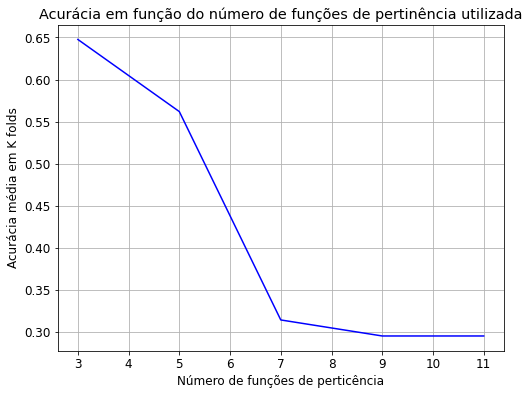

In [13]:
plt.figure(figsize=(8,6))
plt.plot(num_mfs_list, fit_list, c='blue')
plt.title('Acurácia em função do número de funções de pertinência utilizada')
plt.xlabel('Número de funções de perticência')
plt.ylabel('Acurácia média em K folds')
plt.grid()
plt.show()

A melhor combinação de hiperparâmetros encontrada foi

In [14]:
print('Funções de pertinência:', num_mfs_list[np.argmax(fit_list)])
print('Acurácia média no conjunto de teste:', np.max(fit_list))

Funções de pertinência: 3
Acurácia média no conjunto de teste: 0.6476190476190475


Por fim, foi utilizada a melhor combinação de hiperparâmetros em todo o conjunto de treinamento

In [15]:
x_train = TensorDataset(X_train, Y_train.unsqueeze(1))
train_data = DataLoader(x_train, batch_size)
x_train, y_train = train_data.dataset.tensors

x_test = TensorDataset(X_test, Y_test.unsqueeze(1))
test_data = DataLoader(x_test, batch_size)
x_test, y_test = test_data.dataset.tensors

# Gaussiana
print('\nTrain\n')
model = make_anfis(x = x_train, num_mfs = num_mfs_list[np.argmax(fit_list)], num_out = 1, hybrid = False)
model.train(mode = True)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.BCEWithLogitsLoss(reduction = 'sum')
experimental.train_anfis_with(model, train_data, optimizer, criterion, 3)  


print('\nTest\n')
experimental.test_anfis(model, test_data, show_plots = False)
y_hat_test = model(test_data.dataset.tensors[0])

del model

Y_pred = step(y_hat_test)
acc = accuracy_score(y_test.detach().numpy(), Y_pred.detach().numpy())
print('\n\n Accuracy: ', acc)


Train

### Training for 3 epochs, training size = 105 cases
epoch    0: MSE=0.13472, RMSE=0.36704 =inf%
epoch    1: MSE=4.99692, RMSE=2.23538 =inf%
epoch    2: MSE=28.45886, RMSE=5.33468 =inf%

Test

### Testing for 45 cases
MS error=26.24988, RMS error=5.12346, percentage=inf%


 Accuracy:  0.7111111111111111


## Breast Cancer Dataset

In [17]:
K = 5
batch_size = 10

In [18]:
# Reading data
file_path = os.path.abspath('./BreastCancer.csv')
data = pd.read_csv(file_path).drop(['id', 'Unnamed: 32'], axis=1)

Utilizar todas as 30 features do conjunto de dados do Breast Cancer requer cerca de 124GB de RAM para alocar o tensor 3D (`num_rules` $\times$ `n_outs` $\times$ `n_features+1`) de coeficientes do modelo ANFIS, inviabilizando o treinamento da rede na minha máquina. Assim, com o auxílio da matriz de correlações, foram selecionadas apenas algumas features para ajuste do modelo.

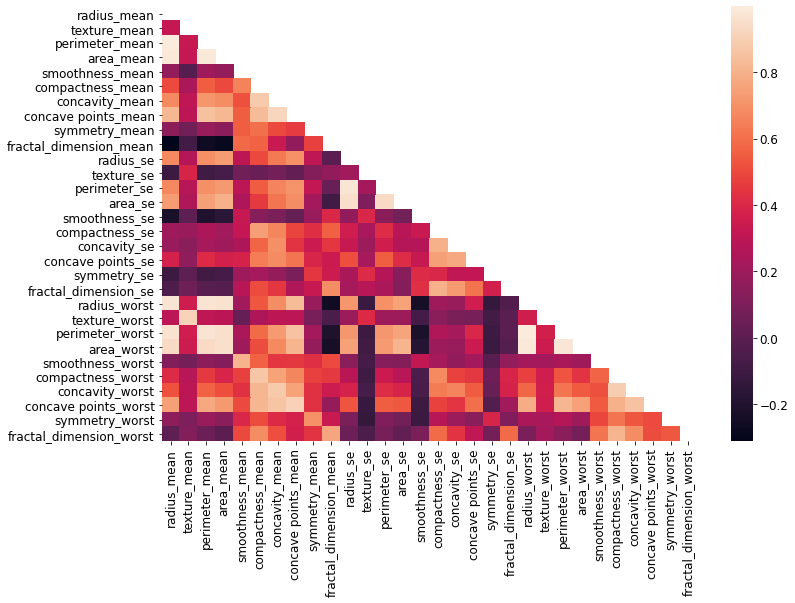

In [19]:
data_corr = data.iloc[:, 1:].corr()
mask = np.triu(np.ones_like(data_corr, dtype=bool))
sns.heatmap(data_corr, mask=mask, annot=False)
plt.show()

Dentre as 30 features, 10 foram selecionadas:

In [20]:
important_features = ['fractal_dimension_mean', 'concave points_mean', 'compactness_mean',
                      'radius_se', 'smoothness_se', 'symmetry_se',
                      'fractal_dimension_se', 'texture_se', 'concavity_worst']

In [21]:
# Input data (removendo rótulos e pegando as features de interesse)
x = data[important_features]
X = torch.Tensor(x.to_numpy())

print('X dim:', X.shape)

X dim: torch.Size([569, 9])


In [22]:
Y = data['diagnosis'].replace({'M': 0, 'B': 1})

Y = torch.Tensor(Y)
print('Y dim:', Y.shape)

Y dim: torch.Size([569])


Assim como no problema anterior, o conjunto de dados foi dividido em 70% para o conjunto de treinamento e 30% para teste.

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [24]:
num_mfs_list = [2, 3]
fit_list = []

for num_mfs in num_mfs_list:
    print('Num mfs: ', num_mfs, '\n')
    acc_list = []
    # K-folds
    for train_idx, valid_idx in get_folds_indices(X_train, Y_train, K):
        
        # Splitting and train and validation sets
        X_K_train, X_K_valid = X_train[train_idx], X_train[valid_idx]
        Y_K_train, Y_K_valid = Y_train[train_idx].unsqueeze(1), Y_train[valid_idx].unsqueeze(1)
        
        # Converting train data
        x_train = TensorDataset(X_K_train, Y_K_train)
        train_data = DataLoader(x_train, batch_size)
        
        # Converting validation data
        x_valid = TensorDataset(X_K_valid, Y_K_valid)
        valid_data = DataLoader(x_valid, batch_size)
        
        x_train, y_train = train_data.dataset.tensors
        print(x_train.shape, y_train.shape)
        
        # Gaussiana
        print('\nTrain\n')
        model = make_anfis(x = x_train, num_mfs = num_mfs, num_out = 1, hybrid = False)
        model.train(mode = True)
        
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
        criterion = torch.nn.BCEWithLogitsLoss(reduction = 'sum')
        experimental.train_anfis_with(model, train_data, optimizer, criterion, 5)
        
        
        print('\nTest\n')
        experimental.test_anfis(model, valid_data, show_plots = False)
        y_hat_test = model(valid_data.dataset.tensors[0])
        
        del model
           
        Y_pred = step(y_hat_test)
        acc = accuracy_score(Y_K_valid.detach().numpy(), Y_pred.detach().numpy())
        print('\n\n Accuracy: ', acc)
        acc_list.append(acc)
        
        print('\n\n\n')
    
    fit_list.append(np.mean(acc_list))

Num mfs:  2 

torch.Size([318, 9]) torch.Size([318, 1])

Train

### Training for 5 epochs, training size = 318 cases
epoch    0: MSE=0.30834, RMSE=0.55529 =inf%
epoch    1: MSE=0.30209, RMSE=0.54963 =inf%
epoch    2: MSE=0.22931, RMSE=0.47886 =inf%
epoch    3: MSE=0.71872, RMSE=0.84778 =inf%
epoch    4: MSE=0.17449, RMSE=0.41772 =inf%

Test

### Testing for 80 cases
MS error=0.20581, RMS error=0.45366, percentage=inf%


 Accuracy:  0.825




torch.Size([318, 9]) torch.Size([318, 1])

Train

### Training for 5 epochs, training size = 318 cases
epoch    0: MSE=0.54566, RMSE=0.73868 =inf%
epoch    1: MSE=0.41104, RMSE=0.64112 =inf%
epoch    2: MSE=0.99515, RMSE=0.99757 =inf%
epoch    3: MSE=0.35186, RMSE=0.59318 =inf%
epoch    4: MSE=0.20666, RMSE=0.45460 =inf%

Test

### Testing for 80 cases
MS error=0.21326, RMS error=0.46180, percentage=inf%


 Accuracy:  0.625




torch.Size([318, 9]) torch.Size([318, 1])

Train

### Training for 5 epochs, training size = 318 cases
epoch    0: MSE=0.4

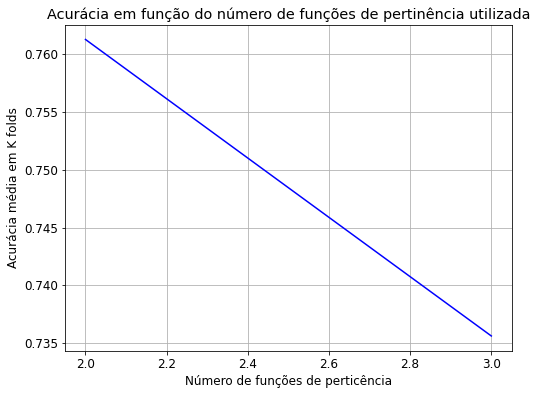

In [25]:
plt.figure(figsize=(8,6))
plt.plot(num_mfs_list, fit_list, c='blue')
plt.title('Acurácia em função do número de funções de pertinência utilizada')
plt.xlabel('Número de funções de perticência')
plt.ylabel('Acurácia média em K folds')
plt.grid()
plt.show()

In [26]:
print('Funções de pertinência:', num_mfs_list[np.argmax(fit_list)])
print('Acurácia média:', np.max(fit_list))

Funções de pertinência: 2
Acurácia média: 0.7612974683544304


Por fim, foi utilizada a melhor combinação de hiperparâmetros em todo o conjunto de treinamento

In [27]:
x_train = TensorDataset(X_train, Y_train.unsqueeze(1))
train_data = DataLoader(x_train, batch_size)
x_train, y_train = train_data.dataset.tensors

x_test = TensorDataset(X_test, Y_test.unsqueeze(1))
test_data = DataLoader(x_test, batch_size)
x_test, y_test = test_data.dataset.tensors

# Gaussiana
print('\nTrain\n')
model = make_anfis(x = x_train, num_mfs = num_mfs_list[np.argmax(fit_list)], num_out = 1, hybrid = False)
model.train(mode = True)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.BCEWithLogitsLoss(reduction = 'sum')
experimental.train_anfis_with(model, train_data, optimizer, criterion, 5)      


print('\nTest\n')
experimental.test_anfis(model, test_data, show_plots = False)
y_hat_test = model(test_data.dataset.tensors[0])

del model

Y_pred = step(y_hat_test)
acc = accuracy_score(y_test.detach().numpy(), Y_pred.detach().numpy())
print('\n\n Accuracy: ', acc)


Train

### Training for 5 epochs, training size = 398 cases
epoch    0: MSE=0.46592, RMSE=0.68258 =inf%
epoch    1: MSE=0.25526, RMSE=0.50523 =inf%
epoch    2: MSE=0.19698, RMSE=0.44382 =inf%
epoch    3: MSE=0.22666, RMSE=0.47609 =inf%
epoch    4: MSE=0.29076, RMSE=0.53922 =inf%

Test

### Testing for 171 cases
MS error=0.29078, RMS error=0.53924, percentage=inf%


 Accuracy:  0.7251461988304093
